In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import cm
from collections import OrderedDict

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score

Rank - Ranking of overall sales

Name - The games name

Platform - Platform of the games release (i.e. PC,PS4, etc.)

Year - Year of the game's release

Genre - Genre of the game

Publisher - Publisher of the game

NA_Sales - Sales in North America (in millions)

EU_Sales - Sales in Europe (in millions)

JP_Sales - Sales in Japan (in millions)

Other_Sales - Sales in the rest of the world (in millions)

Global_Sales - Total worldwide sales.

In [2]:
df = pd.read_csv("vgsales_clean_v2.csv")
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Nintendo
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo
...,...,...,...,...,...,...,...,...,...,...,...,...
16543,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,Nintendo
16544,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,Nintendo
16545,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01,SONY
16546,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,Nintendo


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16548 entries, 0 to 16547
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              16548 non-null  int64  
 1   Name              16548 non-null  object 
 2   Platform          16548 non-null  object 
 3   Year              16548 non-null  float64
 4   Genre             16548 non-null  object 
 5   Publisher         16548 non-null  object 
 6   NA_Sales          16548 non-null  float64
 7   EU_Sales          16548 non-null  float64
 8   JP_Sales          16548 non-null  float64
 9   Other_Sales       16548 non-null  float64
 10  Global_Sales      16548 non-null  float64
 11  Platform Company  16548 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


In [ ]:
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16548.000000,16548.000000,16548.000000,16548.000000,16548.000000,16548.000000,16548.000000
mean,8288.088772,2006.377447,0.265395,0.147022,0.077899,0.048191,0.538782
std,4790.049046,5.905894,0.817791,0.506061,0.309735,0.188858,1.557164
min,1.000000,1970.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4139.750000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8283.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12431.250000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [ ]:
print(df.shape[0])
df['Publisher'] = df['Publisher'].astype('str')

for i in df.columns:
  print("{0:14s} unique value = {1}".format(i, len(np.unique(df[i]))))

16548
Rank           unique value = 16548
Name           unique value = 11458
Platform       unique value = 31
Year           unique value = 43
Genre          unique value = 12
Publisher      unique value = 590
NA_Sales       unique value = 409
EU_Sales       unique value = 305
JP_Sales       unique value = 244
Other_Sales    unique value = 157
Global_Sales   unique value = 623
Platform Company unique value = 10


# What will North America sales look like in 2022?


In [3]:
df_na = df.sort_values(by='NA_Sales', ascending=False)
df_na = df_na[df_na['Year']>2010]
df_na = df_na.drop(["Rank", "Name", "Platform", "EU_Sales", "JP_Sales", "Other_Sales"], axis=1)
df_na = df_na[['Year', 'Genre', 'Publisher', 'Platform Company', 'Global_Sales', 'NA_Sales']]
df_na

,Year,Genre,Publisher,Platform Company,Global_Sales,NA_Sales
23,2013.0,Action,Take-Two Interactive,Microsoft,16.38,9.63
29,2011.0,Shooter,Activision,Microsoft,14.76,9.03
35,2012.0,Shooter,Activision,Microsoft,13.73,8.25
16,2013.0,Action,Take-Two Interactive,SONY,21.40,7.01
61,2013.0,Shooter,Activision,Microsoft,10.21,6.72
...,...,...,...,...,...,...
13541,2015.0,Sports,Konami Digital Entertainment,PC,0.04,0.00
13544,2012.0,Role-Playing,Level 5,SONY,0.04,0.00
8799,2012.0,Action,Konami Digital Entertainment,SONY,0.15,0.00
8790,2015.0,Misc,Square Enix,Nintendo,0.15,0.00


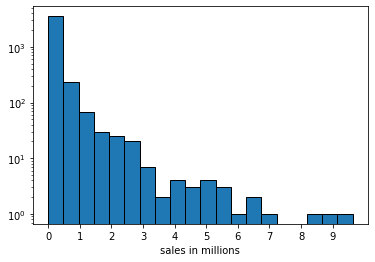

In [6]:
plt.hist(df_na['NA_Sales'], bins = 20, log=True, edgecolor='black')
plt.xticks(np.arange(10))
plt.xlabel("sales in millions")
plt.show()

# prepare data

In [28]:
#input original data for 3 categorical columns in numpy array
#input sw = True => fit_transform, Flase => transform
#output: one hot encode in numpy array
def en_cat(s, sw, o0, o1, o2):
  s0 = s[:, 0].reshape(len(s[:, 0]), 1)
  s1 = s[:, 1].reshape(len(s[:, 1]), 1)
  s2 = s[:, 2].reshape(len(s[:, 2]), 1)

  if sw:
    oe0 = OneHotEncoder()
    oe1 = OneHotEncoder()
    oe2 = OneHotEncoder()
    x0 = oe0.fit_transform(s0).toarray()
    x1 = oe1.fit_transform(s1).toarray()
    x2 = oe2.fit_transform(s2).toarray()
    
    x0 = np.append(x0, x1, axis=1)
    x0 = np.append(x0, x2, axis=1)
    return oe0, oe1, oe2, x0
  else:
    x0 = o0.transform(s0).toarray()
    x1 = o1.transform(s1).toarray()
    x2 = o2.transform(s2).toarray()

    x0 = np.append(x0, x1, axis=1)
    x0 = np.append(x0, x2, axis=1)
    return o0, o1, o2, x0

def transform_input(in_d, sw, o0, o1, o2):
  if sw:
    oe0, oe1, oe2, x = en_cat(in_d[:, 1:4], sw, o0, o1, o2)
    in_d = np.delete(in_d, [1, 2, 3], 1)
    in_d = np.append(in_d, x, axis=1)
    return oe0, oe1, oe2, in_d
  else:
    oe0, oe1, oe2, x = en_cat(in_d[:, 1:4], sw, o0, o1, o2)
    in_d = np.delete(in_d, [1, 2, 3], 1)
    in_d = np.append(in_d, x, axis=1)
    return oe0, oe1, oe2, in_d


In [29]:
data_x = df_na.iloc[:, :-1].values
oe0, oe1, oe2, data_x = transform_input(data_x, True, 0, 0, 0)
data_y = df_na.iloc[:, -1:].values

# split data

In [6]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=.2, random_state=0)

# Feature Scaling

In [7]:
sc_x = StandardScaler()
sc_y = StandardScaler()
train_scx = sc_x.fit_transform(train_x)
train_scy = sc_y.fit_transform(train_y)

# Training dataset

In [8]:
models=[]
models.append(('rbf SVR', SVR(kernel='rbf')))
models.append(('Random Forest', RandomForestRegressor(n_estimators=10, random_state=0)))
models.append(('linear regression', LinearRegression()))
#models.append(('multiple regression', LinearRegression()))
models.append(('decision tree', DecisionTreeRegressor(random_state=0)))

In [10]:

regressor = []
for i in range(len(models)):
  print("training {0} model...".format(models[i][0]))
  regressor.append(models[i][1])
  if i == 0:
    regressor[i].fit(train_scx, train_scy)
  else:
    regressor[i].fit(train_x, train_y)
print("Done!")

training rbf SVR model...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training Random Forest model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


training linear regression model...
training decision tree model...
Done!


# Evaluate

In [11]:
accuracy = []

for i in range(len(models)):
  if i == 0:
    pred_y = sc_y.inverse_transform(regressor[i].predict(sc_x.transform(test_x)))
  else:
    pred_y = regressor[i].predict(test_x)
  print("model {0}, score: {1}".format(models[i][0], r2_score(test_y, pred_y)))
  accuracy.append(r2_score(test_y, pred_y))
  print()

print(models[accuracy.index(max(accuracy))][0], "is the best")

model rbf SVR, score: 0.8305356454236636

model Random Forest, score: 0.9164032799107349

model linear regression, score: -2.7673714233080676e+20

model decision tree, score: 0.8791863788847603

Random Forest is the best


# Test

In [12]:
df_na

,Year,Genre,Publisher,Platform Company,Global_Sales,NA_Sales
23,2013.0,Action,Take-Two Interactive,Microsoft,16.38,9.63
29,2011.0,Shooter,Activision,Microsoft,14.76,9.03
35,2012.0,Shooter,Activision,Microsoft,13.73,8.25
16,2013.0,Action,Take-Two Interactive,SONY,21.40,7.01
61,2013.0,Shooter,Activision,Microsoft,10.21,6.72
...,...,...,...,...,...,...
13541,2015.0,Sports,Konami Digital Entertainment,PC,0.04,0.00
13544,2012.0,Role-Playing,Level 5,SONY,0.04,0.00
8799,2012.0,Action,Konami Digital Entertainment,SONY,0.15,0.00
8790,2015.0,Misc,Square Enix,Nintendo,0.15,0.00


In [32]:
#oe0.transform(np.array([['Action']])).toarray()
#transform_input(np.array([[2022, 'Action', 'Take-Two Interactive', 'Microsoft', 10]]), False)
_, _, _, test_ = transform_input(np.array([[2022, 'Action', 'Take-Two Interactive', 'Microsoft', 10]]), False, oe0, oe1, oe2)

data_x.shape

(1, 245)